# Защита персональных данных клиентов

Нам нужно защитить данные клиентов страховой компании «Хоть потоп». Разработаем такой метод преобразования данных, чтобы по ним было сложно восстановить персональную информацию. Обоснуем корректность его работы.

Нужно защитить данные, чтобы при преобразовании качество моделей машинного обучения не ухудшилось. Подбирать наилучшую модель не станем.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

from sklearn.metrics import r2_score

In [2]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

## Загрузка данных

In [3]:
try:
    df = pd.read_csv('insurance.csv')

except:
    df = pd.read_csv('/datasets/insurance.csv')

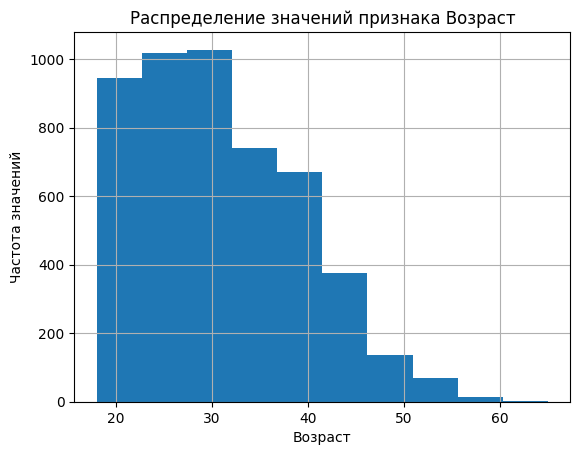

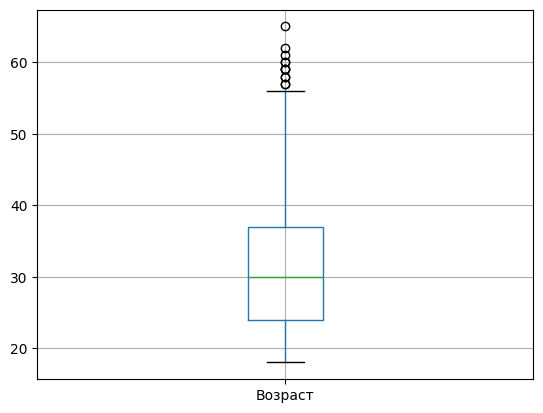

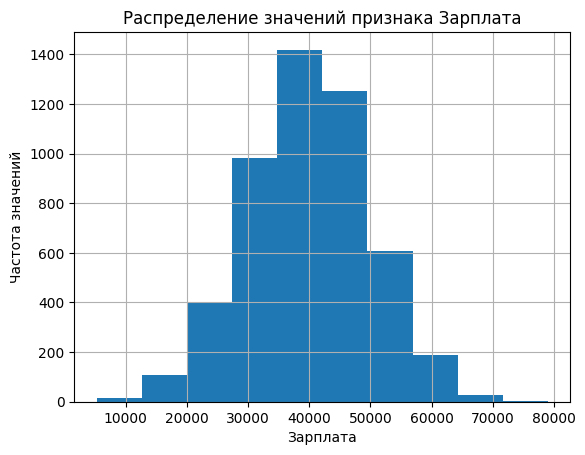

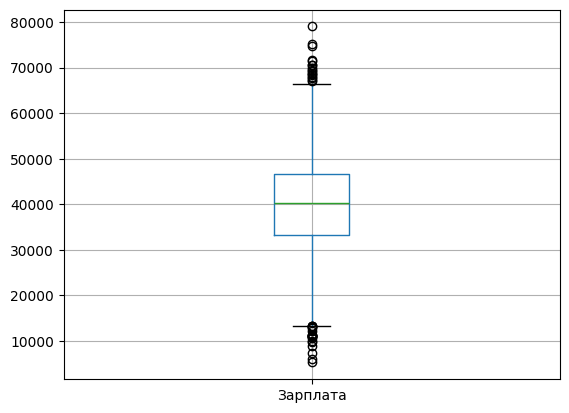

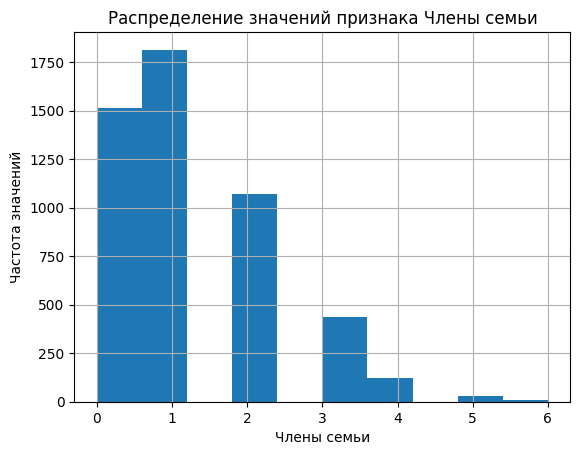

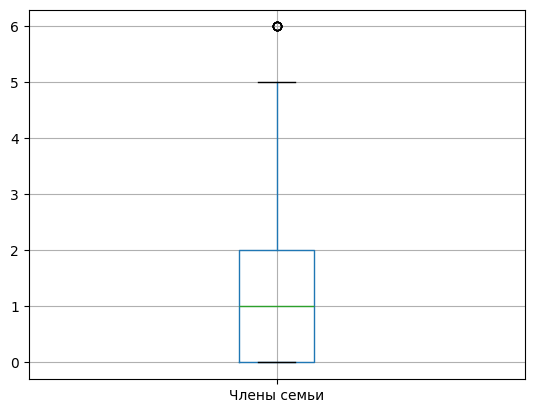

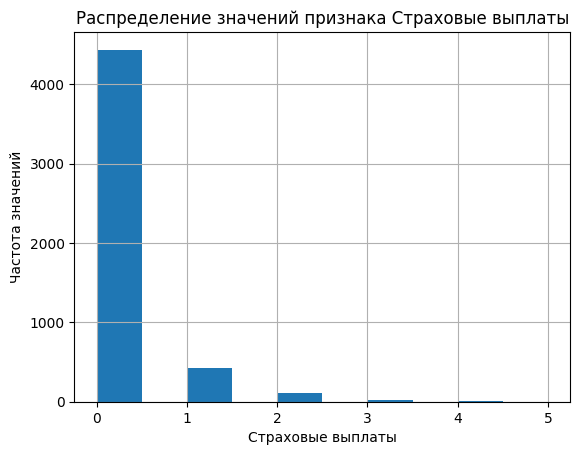

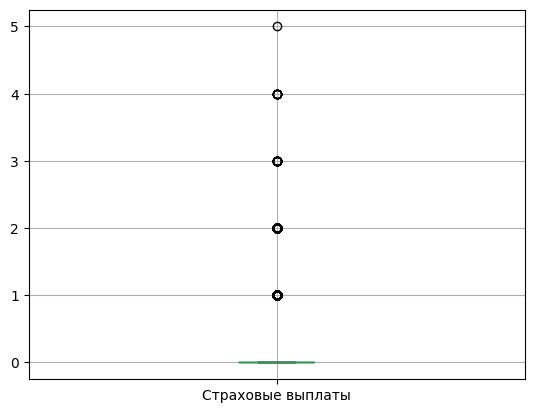

In [4]:
for column in df.columns.drop('Пол'):

    df.hist(column)
    plt.title(f'Распределение значений признака {column}')
    plt.xlabel(f'{column}')
    plt.ylabel('Частота значений')
    plt.show()
    
    df.boxplot(column)


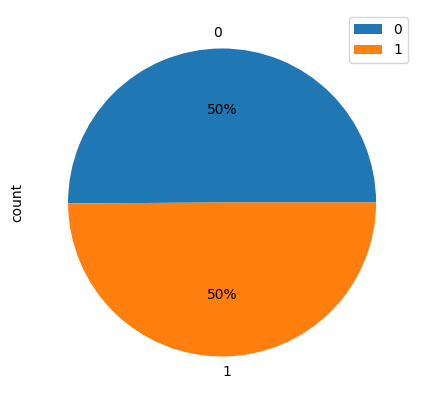

In [5]:
df['Пол'].value_counts().plot(
        kind='pie',
        autopct='%1.f%%',
        #subplots=True,
        figsize=(5, 5),
        legend=True
    )
plt.show()

## Умножение матриц

В этом задании вы можете записывать формулы в *Jupyter Notebook.*

Чтобы записать формулу внутри текста, окружите её символами доллара \\$; если снаружи —  двойными символами \\$\\$. Эти формулы записываются на языке вёрстки *LaTeX.* 

Для примера мы записали формулы линейной регрессии. Можете их скопировать и отредактировать, чтобы решить задачу.

Работать в *LaTeX* необязательно.

Обозначения:

- $X$ — матрица признаков (нулевой столбец состоит из единиц)

- $y$ — вектор целевого признака

- $P$ — матрица, на которую умножаются признаки

- $w$ — вектор весов линейной регрессии (нулевой элемент равен сдвигу)

Предсказания:

$$
a = Xw
$$

Задача обучения:

$$
w = \arg\min_w MSE(Xw, y)
$$

Формула обучения:

$$
w = (X^T X)^{-1} X^T y
$$

**Ответ:** При умножении признаков на обратимую матрицу качество линейной регрессии не изменится, т.к. при подстановке в фаормулу для предсказаний и сравнения их через равенство обратимая матрица становится равной Единичной:

**Обоснование:**
пусть P - обратимая матрица


$$
a = Xw = XEw = XPP^{-1}w = (XP)P^{-1}w = (XP)w'
$$

$$
w' = ((XP)^T XP)^{-1} (XP)^T y
$$
$$
w' = (P^T (X^T X) P)^{-1} (XP)^T y
$$
$$
w' = (P^T P)^{-1} (X^T X)^{-1} X^T P^T y
$$
$$
w' = (P^T)^{-1} P^{-1} (X^T X)^{-1} X^T P^T y
$$
$$
т.к. P^T (P^T)^{-1} = E, тогда:
$$
$$
w' = P^{-1} (X^T X)^{-1} X^T y
$$
$$
т.к. w = (X^T X)^{-1} X^T y, тогда:
$$
$$
w' = P^{-1} w
$$
ч.т.д.

## Алгоритм преобразования

**Алгоритм**
Кодирование будем проводить умножением признаков на обратимую матрицу
$$
a^{'} = XPw
$$


**Обоснование**
исходные признаки можно будет получить умножением на матрицу, обратную P:
$$
a = XPP^{-1}w = XEw = Xw
$$

## Проверка алгоритма

Создадим функцию для разделения датасета на тренировочную и тестовую выборки с возможностью кодирования и получения признаков и кодировщика для изучения работы кодирования

In [6]:
def splitter(data, coding=False, only_features=False):
    coder = None
    features = df.drop('Страховые выплаты', axis=1)
    target = df['Страховые выплаты']
    if coding == True:
        i = 0
        while i < 10:
        
            try:
                coder = np.random.normal(size=(features.shape[1], features.shape[1]))
                features = features @ coder
                numpy.linalg.inv(features)
                i = 10 
            except:
                i += 1
            
            
    features_train, features_test, target_train, target_test = \
    train_test_split(features, target, test_size=0.3, random_state=12345)
    
    
    if only_features == True:
        return features, coder
    return features_train, target_train, features_test, target_test

Посмотрим метрику r2 для данных без кодирования:

In [7]:
features_train, target_train, features_test, target_test = splitter(df)
model = LinearRegression()
model.fit(features_train, target_train)
predictions = model.predict(features_test)
r2_score(target_test, predictions)

0.4305278542485158

Теперь рассмотрим ту же модель но уже на кодированных признаках:

In [8]:
features_train, target_train, features_test, target_test = splitter(df, coding=True)
model.fit(features_train, target_train)
predictions = model.predict(features_test)
r2_score(target_test, predictions)

0.43052785467385624

Результаты R2 идентичны - кодировщик работает верно и не меняет качество работы модели. Проверим возможность восстановления первоначальных признаков:

In [9]:
splitter(df, coding=True, only_features=True)[1]

array([[ 0.02977279,  0.21823684, -0.00347453,  0.02243156],
       [-0.35042163, -1.24353662, -1.58942448,  0.01694738],
       [ 0.19709157,  0.09935637,  0.30477912, -1.37626309],
       [-0.54936648,  0.55093387,  2.22663477, -0.05937924]])

In [10]:
features_prev = splitter(df, coding=False, only_features=True)[0]
features_coded, coder = splitter(df, coding=True, only_features=True)

In [11]:
coder 

array([[ 0.46370264, -1.04439876,  0.34895301, -0.19461924],
       [ 0.40138791,  0.74428967,  0.79627008, -0.62562464],
       [ 0.98285064,  0.09138111, -1.41665128, -1.47396185],
       [-2.74400384, -0.23434095,  0.19610984,  0.70698988]])

In [12]:
encoder = np.linalg.inv(coder) 
new_features = features_coded @ encoder

In [13]:
new_features.head()

,0,1,2,3
0,-1.772813e+07,1.207726e+07,1.848306e+06,4.758921e+06
1,-1.358298e+07,9.253442e+06,1.416203e+06,3.646392e+06
2,-7.506637e+06,5.113936e+06,7.826841e+05,2.015245e+06
3,-1.490360e+07,1.015300e+07,1.553766e+06,4.000527e+06
4,-9.329145e+06,6.355491e+06,9.726684e+05,2.504387e+06


In [14]:
features_prev.head()

,Пол,Возраст,Зарплата,Члены семьи
0,1,41.0,49600.0,1
1,0,46.0,38000.0,1
2,0,29.0,21000.0,0
3,0,21.0,41700.0,2
4,1,28.0,26100.0,0


Результаты совпадают - возможность декодирования подтверждена. 